In [52]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import datetime
import itertools

import pandas as pd
import pandas_datareader.data as web
from pykalman import KalmanFilter
import pywt

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
idx = pd.IndexSlice

DATA_STORE = 'data/assets.h5'
start_year = '2020'
end_year = '2023'

In [53]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/stooq'].loc[start_year: end_year, 'close']

# sp500.describe()
sp500.info

<bound method Series.info of Date
2020-01-02    3257.85
2020-01-03    3234.85
2020-01-06    3246.28
2020-01-07    3237.18
2020-01-08    3253.05
               ...   
2023-03-24    3970.99
2023-03-27    3977.53
2023-03-28    3971.27
2023-03-29    4027.81
2023-03-30    4048.46
Name: close, Length: 817, dtype: float64>

In [54]:
# Smoothing by Kalman Filter based on the assumption of the normally distributed time series data of s&p 500
kf = KalmanFilter(transition_matrices = [1], observation_matrices = [1], initial_state_mean = 0,
                  initial_state_covariance = 1, observation_covariance=1, transition_covariance=.01)

# Estimating the hidden state of the mean of the time series data by forward algorithm
state_means, _ = kf.filter(sp500)
state_means

array([[1628.925     ],
       [2171.32350993],
       [2448.68563117],
       [2615.34966609],
       [2730.93111135],
       [2818.22979278],
       [2883.37348882],
       [2937.90255602],
       [2981.55027013],
       [3018.49352682],
       [3052.82412026],
       [3083.59695761],
       [3109.23248219],
       [3131.67616112],
       [3151.76593827],
       [3166.42868193],
       [3174.20649578],
       [3184.37975716],
       [3193.18027105],
       [3202.06290569],
       [3204.35263557],
       [3208.6827123 ],
       [3217.2877429 ],
       [3228.61511505],
       [3239.89058308],
       [3248.32420444],
       [3258.2720649 ],
       [3267.79541282],
       [3278.47213282],
       [3287.59240435],
       [3296.42876043],
       [3303.4749679 ],
       [3311.35789865],
       [3317.25479597],
       [3319.20747004],
       [3310.31921154],
       [3292.97780689],
       [3276.16539293],
       [3247.85471668],
       [3219.90656054],
       [3207.56523862],
       [3188.133

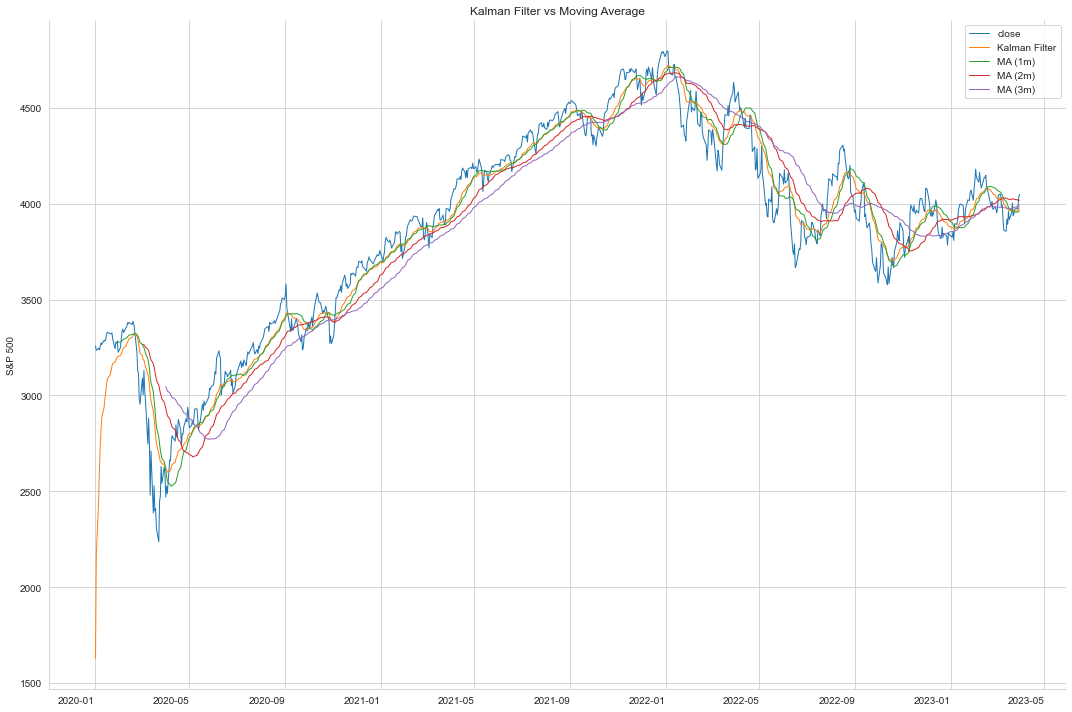

In [55]:
sp500_smoothed = sp500.to_frame('close')
sp500_smoothed['Kalman Filter'] = state_means
for months in [1,2,3]:
    sp500_smoothed[f'MA ({months}m)'] = sp500.rolling(window=months*21).mean()

# The plot of the time series data shows Kalman Filter is more sensitive than MA(1m)
ax = sp500_smoothed.plot(title='Kalman Filter vs Moving Average', figsize=(15,10), lw=1, rot=0)
ax.set_xlabel('')
ax.set_ylabel('S&P 500')
plt.tight_layout()
sns.despine();

In [66]:
pywt.families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

## wavelet is related the Fourier analysis that combines sine and cosine waves to approximating the signal that including noise

# Difference
## - Fourier analysis : better for transforming from the signal of time series to frequency area. but not distinguish the time difference in the signal
## - Wavelet: pattern filtering from various scales(can be time extension or reduction) by matching each frequency area(shifting - moving through time axis), which means simultaneous localization in time and frequency domain. And can approximate the aperiodical or abnormal signal. + Faster than fast Fourier transform -> results : decomposition signal to approximation and detail

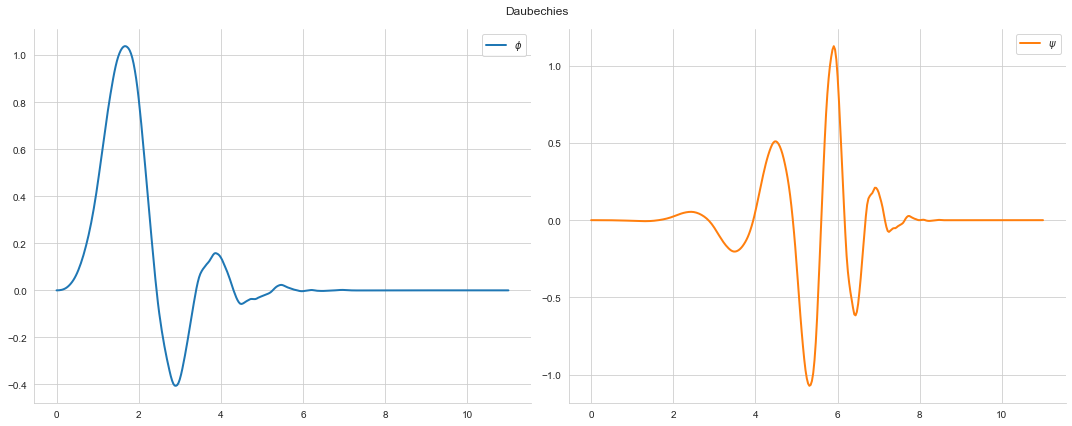

In [63]:
wavelet = pywt.Wavelet('db6')
phi, psi, x = wavelet.wavefun(level=5)
df = pd.DataFrame({'$\phi$': phi, '$\psi$': psi}, index=x)
df.plot(title='Daubechies', subplots=True, layout=(1, 2), figsize=(15, 6), lw=2, rot=0)
plt.tight_layout()
sns.despine();

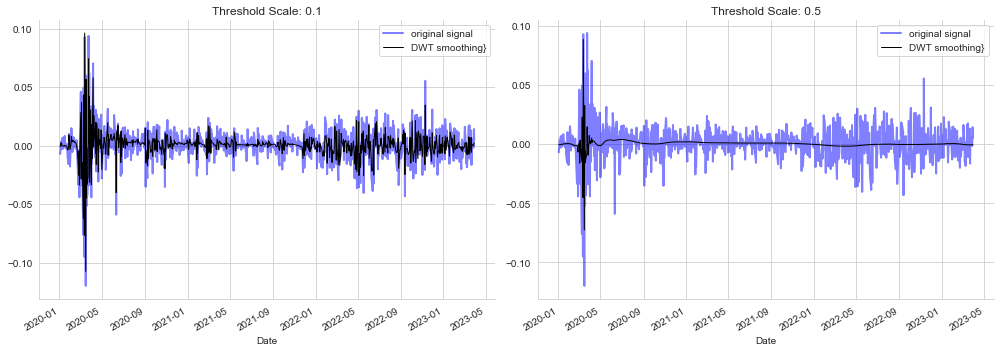

In [70]:
signal = (pd.read_hdf(DATA_STORE, 'sp500/stooq').loc[start_year: end_year].close.pct_change().dropna())

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

wavelet = "db6"
for i, scale in enumerate([.1, .5]):
    # decomposition the signal to get coefficient of wavelet transform
    coefficients = pywt.wavedec(signal, wavelet, mode='per')
    # removing all coefficients over the threshold
    coefficients[1:] = [pywt.threshold(i, value=scale*signal.max(), mode='soft') for i in coefficients[1:]]
    # inverse transformation to construct signal
    reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
    signal.plot(color="b", alpha=0.5, label='original signal', lw=2,
                 title=f'Threshold Scale: {scale:.1f}', ax=axes[i])
    pd.Series(reconstructed_signal, index=signal.index).plot(c='k', label='DWT smoothing}', linewidth=1, ax=axes[i])
    axes[i].legend()
fig.tight_layout()
sns.despine();